<a href="https://colab.research.google.com/github/DmytroBuzanov/DS_ML/blob/main/Prophet/One_month_values_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

plt.style.use('fivethirtyeight') # For plots

!pip install pandas_profiling
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
import pandas_profiling

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_features = pd.read_excel('/content/drive/My Drive/data/features_variables_values.xlsx', sheet_name='features_variables', usecols= ['date', 'value'], index_col=0,parse_dates=[0])
df_target = pd.read_excel('/content/drive/My Drive/data/features_variables_values.xlsx', sheet_name='target_variable', usecols= ['date', 'target variable'], index_col=0, parse_dates=[0])
df_features.head()

value
date                
2010-01-01  1.026836
2010-01-04  1.042078
2010-01-05  1.067851
2010-01-06  1.058734
2010-01-07  1.072427

****
# EDA

In [ ]:
df_features.describe()

value
count  56999.000000
mean      31.716066
std       91.215538
min        0.007996
25%        0.556768
50%        1.499000
75%        2.868500
max      766.140000

In [ ]:
df_target.describe()

target variable
count      3000.000000
mean       2161.426460
std         771.074463
min        1022.580017
25%        1432.450043
50%        2071.239990
75%        2728.182617
max        4319.939941

In [ ]:
pd.read_excel(r'/content/drive/My Drive/data/features_variables_values.xlsx', sheet_name='features_variables').profile_report()

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
pd.read_excel(r'/content/drive/My Drive/data/features_variables_values.xlsx', sheet_name='target_variable').profile_report()

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

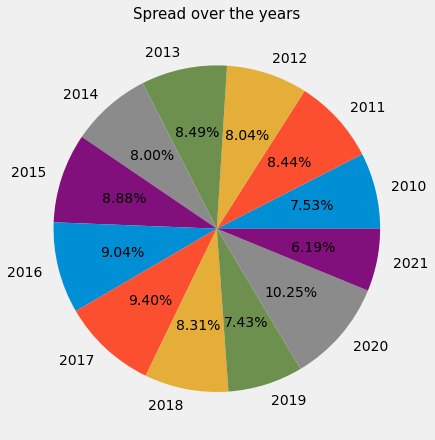

In [ ]:
df = pd.read_excel('/content/drive/My Drive/data/features_variables_values.xlsx', sheet_name='features_variables')

df['Year'] = df['date'].dt.year

df.groupby('Year')['value'].sum().plot(kind = 'pie', autopct = '%.2f%%', figsize=(7,7)).set(ylabel='')
plt.title('Spread over the years', fontsize = 15)
plt.show()

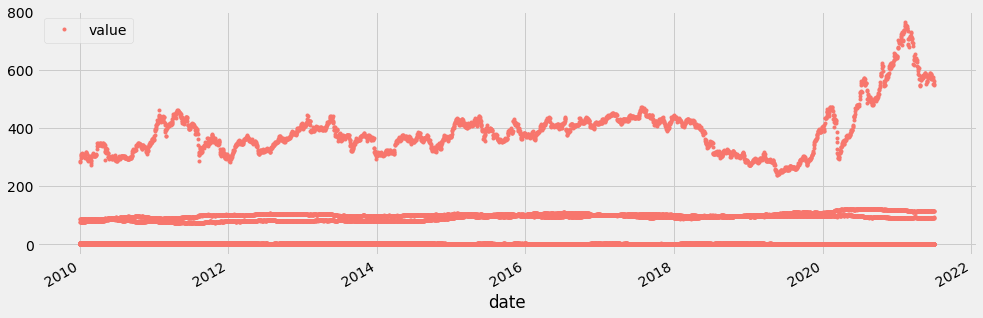

In [ ]:
df_features.plot(style='.', figsize=(15,5), color="#F8766D")
plt.show()

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = pd.to_datetime(df['date'], errors='coerce')
    df['month'] = pd.to_datetime(df['date'], errors='coerce')
    df['year'] = pd.to_datetime(df['date'], errors='coerce')
    df['dayofyear'] = pd.to_datetime(df['date'], errors='coerce')
    df['dayofmonth'] = pd.to_datetime(df['date'], errors='coerce')
    df['weekofyear'] = pd.to_datetime(df['date'], errors='coerce')
    X = df[['dayofweek', 'month','year',
          'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df_features, label='value')

features_and_target = pd.concat([X, y], axis=1)
features_and_target.head()

dayofweek      month       year  ... dayofmonth weekofyear     value
date                                         ...                                
2010-01-01 2010-01-01 2010-01-01 2010-01-01  ... 2010-01-01 2010-01-01  1.026836
2010-01-04 2010-01-04 2010-01-04 2010-01-04  ... 2010-01-04 2010-01-04  1.042078
2010-01-05 2010-01-05 2010-01-05 2010-01-05  ... 2010-01-05 2010-01-05  1.067851
2010-01-06 2010-01-06 2010-01-06 2010-01-06  ... 2010-01-06 2010-01-06  1.058734
2010-01-07 2010-01-07 2010-01-07 2010-01-07  ... 2010-01-07 2010-01-07  1.072427

[5 rows x 7 columns]

# Train/Test Split



In [ ]:
df_features_train = df_features 
df_features_test = df_target 

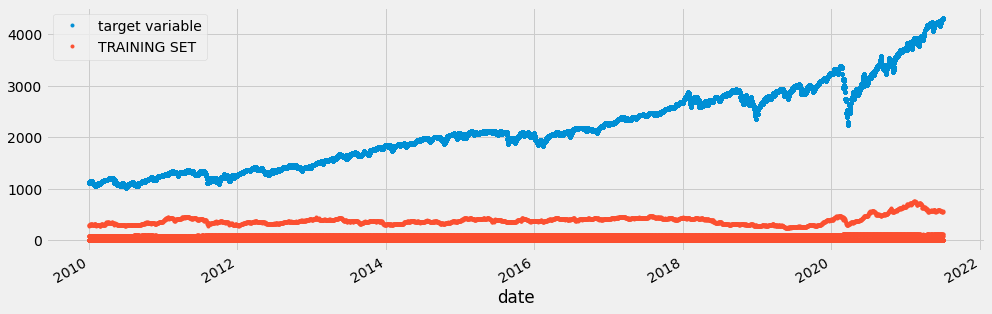

In [ ]:
# Plot train and test so you can see where we have split
df_features_test \
    .rename(columns={'value': 'TEST SET'}) \
    .join(df_features_train.rename(columns={'value': 'TRAINING SET'}),
          how='left', lsuffix='_left', rsuffix='_right') \
    .plot(figsize=(15,5), style='.') # title='PJM East'
plt.show()

# Prophet Model


In [ ]:
# Format data for prophet model using ds and y
df_features_train.reset_index() \
    .rename(columns={'date':'ds',
                     'value':'y'}).head()

ds         y
0 2010-01-01  1.026836
1 2010-01-04  1.042078
2 2010-01-05  1.067851
3 2010-01-06  1.058734
4 2010-01-07  1.072427

In [ ]:
# Setup and train model and fit
model = Prophet()
model.fit(df_features_train.reset_index() \
              .rename(columns={'date':'ds',
                               'value':'y'}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Predict on training set with model
df_features_test_fcst = model.predict(df=df_features_test.reset_index() \
                                   .rename(columns={'date':'ds'}))

In [ ]:
df_features_test_fcst.head()

ds      trend  ...  multiplicative_terms_upper       yhat
0 2010-01-01  22.578596  ...                         0.0  27.012053
1 2010-01-04  22.598284  ...                         0.0  27.146417
2 2010-01-05  22.604846  ...                         0.0  27.197087
3 2010-01-06  22.611408  ...                         0.0  27.239329
4 2010-01-07  22.617971  ...                         0.0  27.273692

[5 rows x 19 columns]

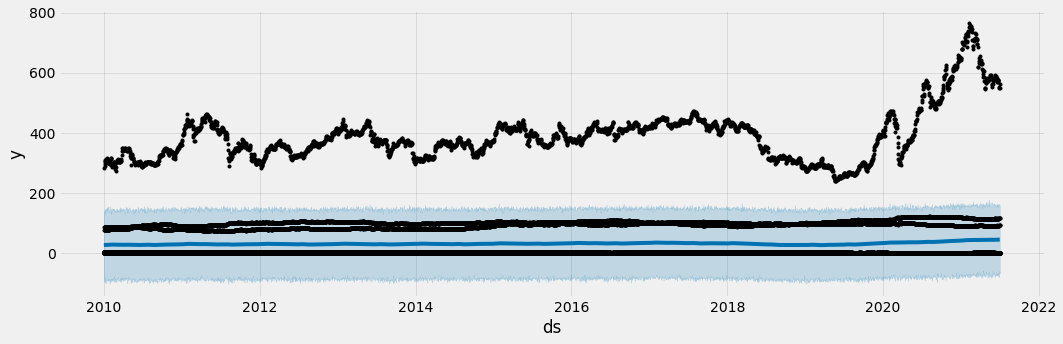

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_features_test_fcst,
                 ax=ax)
plt.show()

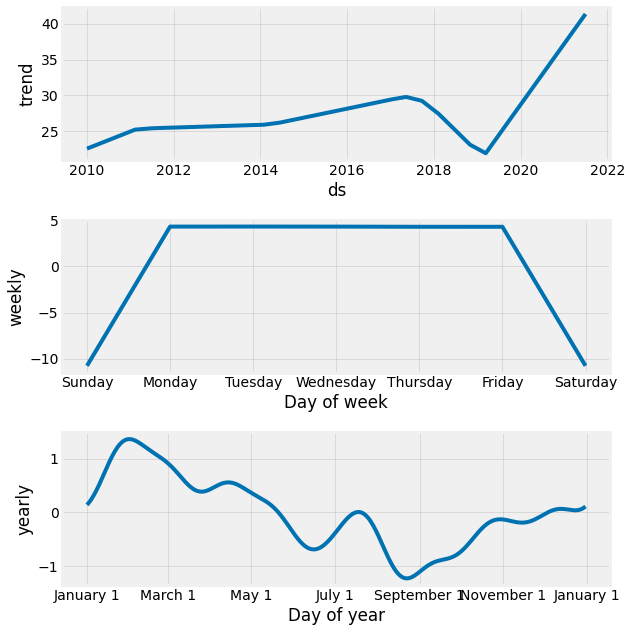

In [ ]:
# Plot the components of the model
fig = model.plot_components(df_features_test_fcst)

# Compare Forecast to Actuals

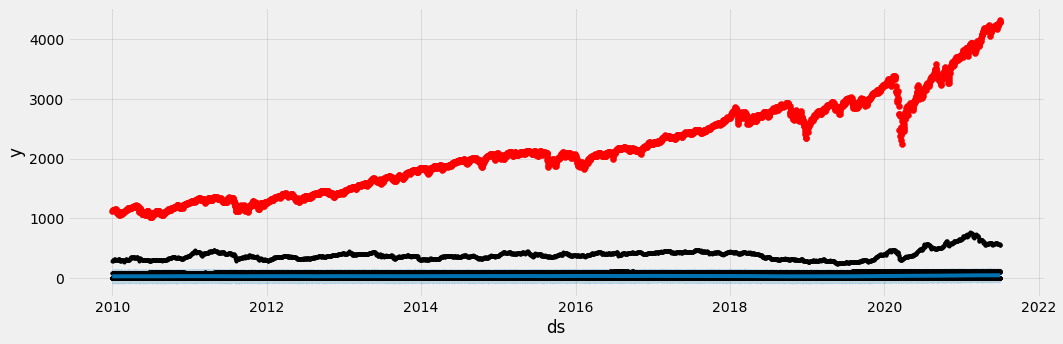

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_features_test.index, df_features_test['target variable'], color='r')
fig = model.plot(df_features_test_fcst, ax=ax)

In [ ]:
df_features_test_fcst

ds      trend  ...  multiplicative_terms_upper       yhat
0    2010-01-01  22.578596  ...                         0.0  27.012053
1    2010-01-04  22.598284  ...                         0.0  27.146417
2    2010-01-05  22.604846  ...                         0.0  27.197087
3    2010-01-06  22.611408  ...                         0.0  27.239329
4    2010-01-07  22.617971  ...                         0.0  27.273692
...         ...        ...  ...                         ...        ...
2995 2021-06-25  41.226967  ...                         0.0  44.961569
2996 2021-06-28  41.296363  ...                         0.0  45.132990
2997 2021-06-29  41.319496  ...                         0.0  45.191336
2998 2021-06-30  41.342628  ...                         0.0  45.238770
2999 2021-07-01  41.365760  ...                         0.0  45.275830

[3000 rows x 19 columns]

In [ ]:
plot_plotly(model, df_features_test_fcst)